# Error Characterization of HERMES
Understanding the sources of error of an integrator is essential for many reasons. It makes debugging much faster, adding new modules much easier, and operation more efficient.  

In [1]:
import rebound
import numpy as np
import time as timing

## Setup
First let's set up the problem consisting of a central star, massive planet and passive planetesimal. The planetesimal begins inside the $HSF$ boundary of the planet so that the simulation begins in pure IAS15 mode. We initialize the planetesimal such that the planet-planetesimal distance grows with time. Soon after, the planetesimal leaves the $HSF$ boundary and the simulation finishes in pure WHFAST mode. 

In Silburt et al. (2016) we calculate theoretical predictions for the error introduced, and we input these predictions so we can directly compare to our numerical tests.

In [2]:
def theory(sys_params, x, choice, scale_factor):
    HSF, dt, a, M, m_p, m_pl = sys_params
    
    if choice == "dt":
        dt = x
    elif choice == "HSF":
        HSF = x
    elif choice == "a":
        a = x
    elif choice == "m_p":
        m_p = x
    elif choice == "m_pl":
        m_pl = x
        
    rhHSF = HSF*a*(m_p/(3*M))**(1./3.)
    coeff = (dt**2 / 12.)*m_p*m_pl/(rhHSF**2)
    term1 = 1/(a*rhHSF)
    term2 = m_p/(rhHSF**2)
    term3 = -rhHSF/(2*((a*a - rhHSF**2)**1.5))
    theoretical = (term1 + term2 + term3)*coeff*scale_factor
    axes[0].plot(x, theoretical, '+-',label='R3B theory')

In [3]:
def problem(HSF, dt, a_p, m_p, m_pl, theta):
    #initialize the simulation
    sim = rebound.Simulation()
    
    #integrator options
    sim.integrator = "hermes"
    sim.ri_hermes.hill_switch_factor = HSF
    sim.ri_hermes.radius_switch_factor = 20.
    sim.dt = dt
    sim.testparticle_type = 1
    tmax = 7. * a_p**1.5
    sim.usleep = -1

    #collision and boundary options
    sim.collision = "direct"
    sim.collision_resolve = "merge"
    sim.track_energy_offset = 1
    sim.collision_resolve_keep_sorted = 1
    
    #massive bodies
    M = 1.
    sim.add(m=M)
    sim.add(m=m_p,r=1.6e-4,a=a_p,e=0,inc=0.0001,f=0)
    sim.N_active = sim.N
    
    #planetesimal
    rr = 1e-3
    dr = rr*a_p*a_p*np.sin(theta - np.pi/2.)
    sim.add(m=m_pl,r=4e-5,a=sim.particles[sim.N_active-1].x+dr,f=rr*np.sin(theta))
    
    #planetesimal trajectory modification
    escape_velocity = (2*sim.G*m_p/rr)**0.5
    fac = 0.3    #numerical factor to make this work for all ranges of 'a'
    if a_p < 1:
        fac = 0.7
    vx = np.cos(theta)*escape_velocity / a_p
    vy = np.sin(theta)*escape_velocity / a_p**fac
    sim.particles[sim.N-1].vx -= vx + 0.2*vx*np.cos(theta) #slight boost to increase planet-planetesimal distance
    sim.particles[sim.N-1].vy += vy + 0.2*vy*np.sin(theta)
    
    #final physics initialization stuff
    sim.move_to_com()
    E0 = sim.calculate_energy()
    dE = []
    times = np.linspace(0,tmax,150)
    
    start_t = timing.time()
    for t in times:
        sim.integrate(tmax)
        dE.append(np.fabs((sim.calculate_energy() - E0)/E0))
    time = timing.time() - start_t
    dE_max = max(dE)
    
    #recall time is in units of yr/2pi
    return HSF, dt/(2*np.pi), a_p, dE_max, time, np.fabs(dE_max/E0)/dE_max, M, m_p, m_pl

### Choose Parameter Space
Now let's choose which variable we're investigating, either $dt$ or $HSF$, and set up the parameter space that we're going to search.

In [4]:
choice = "dt"     #can be "HSF", "dt", "a", "m_p", or "m_pl"
n_runs = 150       #number of searches in the parameter space

#set up parameter space
ones = np.ones(n_runs)
dt = 1e-3*ones
HSF = 6.*ones
a = ones
m_p = 5e-5*ones
m_pl = 1e-8*ones
theta = np.random.uniform(low=0.15,high=0.85,size=n_runs)*np.pi

if choice == "HSF":
    HSF = np.logspace(-2,1.7,n_runs)
elif choice == "dt":
    dt = np.logspace(-5,0,n_runs)
elif choice == "a":
    a = np.logspace(-1,1,n_runs)
elif choice == "m_p":
    m_p = np.logspace(-3,-6,n_runs)
elif choice == "m_pl":
    m_pl = np.logspace(-10,-5,n_runs)
    
params = zip(HSF,dt,a,m_p,m_pl,theta)

### Calculate
Calculate the results. This might take a minute or two.

In [18]:
import multiprocessing as mp
import pandas as pd

def execute(pars):
    return problem(pars[0],pars[1],pars[2],pars[3],pars[4],pars[5]);

if __name__== '__main__':
    results = []
    pool = mp.Pool(processes=len(params));
    results.append(pool.map(execute, params));
    pool.close()
    pool.join()
    data = pd.DataFrame(results[0],columns=["HSF","dt","a","dE","time","scale_factor","M","m_p","m_pl"])

/Users/silburt/phd/rebound/rebound/simulation.py:305: RuntimeWarning: The timestep is likely too large. Close encounters might be missed. Decrease the timestep or increase the switching radius. This warning will appear only once.
  warnings.warn(msg[1:], RuntimeWarning)
/Users/silburt/phd/rebound/rebound/simulation.py:305: RuntimeWarning: The timestep is likely too large. Close encounters might be missed. Decrease the timestep or increase the switching radius. This warning will appear only once.
  warnings.warn(msg[1:], RuntimeWarning)
/Users/silburt/phd/rebound/rebound/simulation.py:305: RuntimeWarning: The timestep is likely too large. Close encounters might be missed. Decrease the timestep or increase the switching radius. This warning will appear only once.
  warnings.warn(msg[1:], RuntimeWarning)
/Users/silburt/phd/rebound/rebound/simulation.py:305: RuntimeWarning: The timestep is likely too large. Close encounters might be missed. Decrease the timestep or increase the switching r

### Plot
Great, now let's plot the results, showing the energy error and elapsed time as a function of our chosen variable.

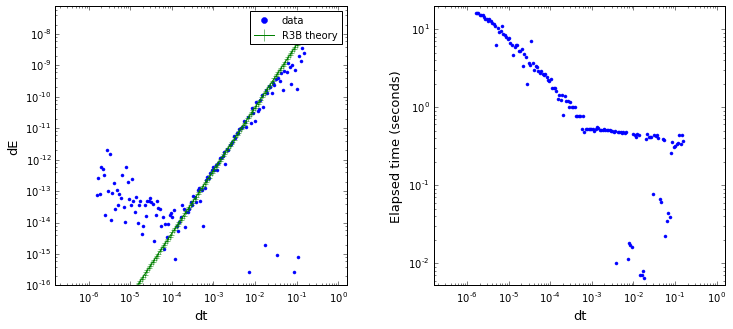

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

if choice == "HSF":
    x = data["HSF"]
elif choice == "dt":
    x = data["dt"]
elif choice == "a":
    x = data["a"]
elif choice == "m_p":
    x = data["m_p"]
elif choice == "m_pl":
    x = data["m_pl"]
sys_params = data.loc[0,["HSF","dt","a","M","m_p","m_pl"]].values
    
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12,5))
plt.subplots_adjust(wspace=0.3)
axes[0].plot(x,data["dE"],'.',label="data")
axes[0].set_ylim([1e-16,10*max(data["dE"])])
axes[0].set_xlim([min(x)/10., max(x)*10])
axes[0].set_xlabel(choice,fontsize=13)
axes[0].set_ylabel('dE',fontsize=13)
axes[0].set_yscale('log')
axes[0].set_xscale('log')
theory(sys_params,x,choice,data["scale_factor"].mean())
axes[0].legend(loc='upper right',prop={'size':10}, numpoints=1, markerscale=2)
axes[1].plot(x,data["time"],'.')
axes[1].set_ylim([0.8*data["time"].min(),1.2*data["time"].max()])
axes[1].set_xlabel(choice,fontsize=13)
axes[1].set_ylabel('Elapsed time (seconds)',fontsize=13)
axes[1].set_yscale('log')
plt.savefig('HERMES_Error_'+choice+'.png')